## Setup the Model ##

<IPython.core.display.Javascript object>


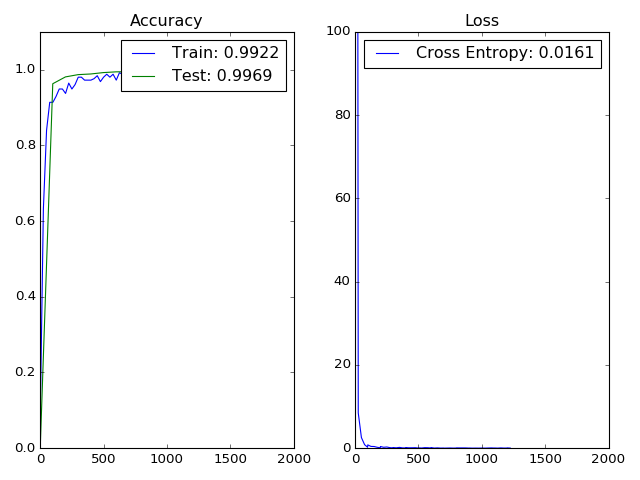

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
step 0, training accuracy 0.078125
step 25, training accuracy 0.632812
step 50, training accuracy 0.839844
step 75, training accuracy 0.914062
step 99, test accuracy 0.963157
Model saved in file: /tmp/model.ckpt
step 100, training accuracy 0.914062
step 125, training accuracy 0.929688
step 150, training accuracy 0.949219
step 175, training accuracy 0.949219
step 199, test accuracy 0.98119
Model saved in file: /tmp/model.ckpt
step 200, training accuracy 0.9375
step 225, training accuracy 0.964844
step 250, training accuracy 0.949219
step 275, training accuracy 0.960938
step 299, test accuracy 0.987202
Model saved in file: /tmp/model.ckpt
step 300, training accuracy 0.980469
step 325, training accuracy 0.980469
step 350, training accuracy 0.972656
step 375, training a

In [1]:
from __future__ import print_function

%matplotlib notebook 

import tensorflow as tf
import numpy as np

from os.path import join
from helper_functions import *
from visualization import Visualization
from sklearn.model_selection import train_test_split


class DigitClassifier(object):

    """Train a convolutional network with `data` and optional `filter_type` parameter."""
    def __init__(self, filter_type='original', EPOCHS=2000, LEARNING_RATE=1e-3, BATCH_SIZE=256, model_path = "/tmp/model.ckpt", ):
        self.EPOCHS = EPOCHS
        self.LEARNING_RATE = LEARNING_RATE
        self.BATCH_SIZE = BATCH_SIZE
        self.model_path = model_path
        print("Network initialized: ", self.EPOCHS, self.LEARNING_RATE, self.BATCH_SIZE)
        try:
            self.train_network()
        except:
            print("Model closed abruptly.")
        
    def train_network(self):
        '''Train the network.'''
        self._index_in_epoch = 0
        self._epochs_completed = 0
        viz = Visualization(epochs=self.EPOCHS)
        
        # Load train and test sets
        x_train, self.y_train, x_test, self.y_test = self.load_data()
        self._num_examples = len(x_train)
        
        # Flatten training and test images
        self.x_train = x_train.reshape((self._num_examples,-1))
        _num_test_samples = len(x_test)
        self.x_test = x_test.reshape((_num_test_samples,-1))        

        # Explicitly initialize graph
        tf.reset_default_graph()
        
        global_step = tf.Variable(0, name='global_step', trainable=False)

        # Initialize input and target tensors
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')
            tf.add_to_collection('x-input', x)
            tf.add_to_collection('y-input', y_)

        # Initialize weight and bias tensors
        with tf.name_scope('convolutional_layer_1'):
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])

        with tf.name_scope('input_reshape'):
            x_image = tf.reshape(x, [-1,28,28,1])
            tf.summary.image('input', x_image, 10)

        with tf.name_scope('convolutional_layer1'):
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

        with tf.name_scope('pooling_layer_1'):
            h_pool1 = max_pool_2x2(h_conv1)

        with tf.name_scope('convolutional_layer_2'):
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])        
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

        with tf.name_scope('pooling_layer_2'):
            h_pool2 = max_pool_2x2(h_conv2)

        with tf.name_scope('fully_connected_layer_1'):
            W_fc1 = weight_variable([7 * 7 * 64, 512])
            b_fc1 = bias_variable([512])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        with tf.name_scope('dropout'):
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            tf.add_to_collection('keep_prob', self.keep_prob)
            tf.summary.scalar('dropout_keep_probability', self.keep_prob)
            h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)                    

        with tf.name_scope('fully_connected_layer_2'):
            W_fc2 = weight_variable([512, 10])
            b_fc2 = bias_variable([10])
            self.y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            tf.add_to_collection("y_conv", self.y_conv)

        with tf.name_scope('cross_entropy'):
            # The raw formulation of cross-entropy,
            #
            # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
            #                               reduction_indices=[1]))
            #
            # can be numerically unstable.
            #
            # So here we use tf.nn.softmax_cross_entropy_with_logits on the
            # raw outputs of the nn_layer above, and then average across
            # the batch.

            diff = tf.nn.softmax_cross_entropy_with_logits(self.y_conv, y_)
            with tf.name_scope('total'):
                cross_entropy = tf.reduce_mean(diff)

        tf.summary.scalar('cross_entropy', cross_entropy)
        tf.add_to_collection('cross_entropy', cross_entropy)

        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.LEARNING_RATE).minimize(cross_entropy, global_step=global_step)
            tf.add_to_collection('train_op', self.train_step)

        with tf.name_scope('accuracy'):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(self.y_conv, 1), tf.argmax(y_, 1))
                tf.add_to_collection('correct_prediction', correct_prediction)
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.add_to_collection('accuracy', accuracy)
        tf.summary.scalar('accuracy', accuracy)

        # Add an op to initialize the variables.
        init_op = tf.global_variables_initializer()

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init_op)

            # Merge all the summaries and write them out to `./logs`
            dir_path = os.path.abspath('')
            log_dir=join(dir_path,'logs-' + str(self.EPOCHS) + '-' + str(self.BATCH_SIZE) + '-' + str(self.LEARNING_RATE))        
            merged = tf.summary.merge_all()
            train_writer = tf.summary.FileWriter(join(log_dir,'train'),
                                          sess.graph)
            test_writer = tf.summary.FileWriter(join(log_dir,'test'))
            
            # Set target test accuracy for save benchmarking
            best_accuracy = 0.90
            # Create index of test accuracy for comparison
            self.accuracies = []
            
            try:
                for epoch in range(self.EPOCHS):
                    batch_x, batch_y = self.next_batch(self.BATCH_SIZE)    
                    summary, _, acc, cross_entropy_loss = sess.run([merged, self.train_step, accuracy, cross_entropy], feed_dict={x : batch_x, y_ : batch_y, self.keep_prob: 0.5})

                    if epoch % 100 == 99: # Record train set summaries, and test                
                        run_metadata = tf.RunMetadata()
                        train_writer.add_run_metadata(run_metadata, 'step%03d' % epoch)

                        # Add training summary
                        train_writer.add_summary(summary, epoch)

                        summary, test_accuracy, cross_entropy_loss = sess.run([merged, accuracy, cross_entropy], feed_dict={x : self.x_test, y_ : self.y_test, self.keep_prob: 1.0})
                        print("step %d, test accuracy %g"%(epoch, test_accuracy))
                        viz(epoch, test=test_accuracy, cross_entropy=cross_entropy_loss)
                        test_writer.add_summary(summary, epoch)
                        if test_accuracy > best_accuracy:
                            best_accuracy = test_accuracy
                            # Save model weights to disk
                            save_path = saver.save(sess, self.model_path)
                            print("Model saved in file: %s" % save_path)
                            self.accuracies.append(test_accuracy)

                    # Visualize training progress every 25 steps
                    if epoch % 25 == 0:                            
                        print("step %d, training accuracy %g"%(epoch, acc))
                        viz(epoch, train=acc, cross_entropy=cross_entropy_loss)
            finally:
                # Save model weights to disk at the end
                save_path = saver.save(sess, "/tmp/model-final.ckpt")
                print("Model saved in file: %s" % save_path)
                train_writer.close()
                test_writer.close()
            
    def next_batch(self, batch_size=100, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.x_train[perm0]
            self._labels = self.y_train[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self.x_train[start:self._num_examples]
            labels_rest_part = self.y_train[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch            
            return self._images[start:end], self._labels[start:end]
        
    def __call__(self,feed_list=None, model_path='/tmp/model-final.ckpt', misclassified=False):        
        '''Classify images and if `misclassified` argument is passed, access misclassified images.'''
        print("Function initiated")
        if misclassified:
            # Get misclassified images.
            feed_list=[self.x_test,self.y_test,1.0]
        x, y_ = self.get_placeholders()
        accuracy = tf.get_collection('accuracy')[0]
        feed_dict = {x : feed_list[0], y_: feed_list[1], self.keep_prob:feed_list[2]}
        misclass = tf.not_equal(tf.argmax(self.y_conv, 1), tf.argmax(y_, 1))
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            init_op = tf.global_variables_initializer()

            # Initialize variables
            sess.run(init_op)
            # Restore model weights from previously saved model
            saver.restore(sess, self.model_path)
            print("Model restored from file: %s" % self.model_path)
            
            classification, accuracy, misclassified_array = sess.run([self.y_conv, accuracy, misclass], feed_dict)        
            misclassified_list = np.where(misclassified_array)[0].tolist()

            if misclassified:
                # Show first `n` misclassified images
                n = 2
                print(len(misclassified_list), " misclassified images out of ", len(self.x_test))
                for i in misclassified_list[:n]: 
                    plt.figure()
                    prediction = np.argmax(classification[i])
                    correct = np.argmax(self.y_test[i])
                    plt.title("PREDICTION: " + str(prediction) + ' CORRECT: '+ str(correct))
                    plt.imshow(self.x_test[i].reshape(28,28), cmap='gray')
                    plt.show()

            return classification, self.x_test, self.y_test, misclassified_list
    
    def classify(self,images,labels, imshow=False):
        '''Predict classification for individual images.'''
        if labels.shape[0] == 10:
            labels = [labels]            
        x, y_ = self.get_placeholders()
        
        with tf.Session() as sess:
            init_op = tf.global_variables_initializer()
            saver = tf.train.Saver()
            # Initialize variables
            sess.run(init_op)
            # Restore model weights from previously saved model
            saver.restore(sess, self.model_path)
            print("Model restored from file: %s" % self.model_path)
            self.output = sess.run([self.y_conv],feed_dict={x: images, y_: labels, self.keep_prob:1.0})
            if imshow:
                for ind, image in enumerate(images):                    
                    f, ax = plt.subplots()
                    ax.set_title('PREDICTION: ' + str(np.argmax(self.output[0][ind])) +' CORRECT: ' + str(np.argmax(labels[ind])))
                    ax.imshow(image.reshape(28,28), cmap='gray')
                    plt.axis('off')
                    plt.show()
            print("Classified images")
        return self.output

    def get_placeholders(self):
        x = tf.get_default_graph().get_tensor_by_name("input/x-input:0")
        y_ = tf.get_default_graph().get_tensor_by_name("input/y-input:0")    
        return x, y_
    
    def load_data(self):
        '''Load data from pickle files.'''
        try:
            x_train = pickle.load(open('x_train.p','rb'))
            x_test = pickle.load(open('x_test.p','rb'))
            y_train = pickle.load(open('y_train.p','rb'))
            y_test = pickle.load(open('y_test.p','rb'))            
            return x_train, y_train, x_test, y_test
        except IOError:
            try:    
                data = pickle.load(open('data3_4.p', 'rb'))
                _x_data, _y_data = collect_images(data)                
                target = np.zeros((len(_y_data), 10))
                target[np.arange(len(_y_data)),_y_data] = 1
                _y_data = target
                x_train, x_test, y_train, y_test = train_test_split(_x_data,_y_data,random_state=42)
                pickle.dump(x_test, open('x_test.p','wb'))
                pickle.dump(x_train, open('x_train.p','wb'))
                pickle.dump(y_train, open('y_train.p','wb'))
                pickle.dump(y_test, open('y_test.p','wb'))
                return x_train, y_train, x_test, y_test
            except IOError:
                print("Data file missing.")
        
digit_classifier = DigitClassifier('original')

In [ ]:
classification, imgs, y_test, misclassified_list = digit_classifier(misclassified=True)

In [15]:
def timefunc():
    from time import time, sleep
    x_test = pickle.load(open('x_test.p','rb'))
    y_test = pickle.load(open('y_test.p','rb'))
    sleep(5)
    then = time()
    digit_classifier.classify(x_test.reshape((-1,784)),y_test)[0]
    print(time() - then)

timefunc()

Model restored from file: /tmp/model.ckpt
Classified images
1.28633499146
